In [18]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.misc import comb
from sklearn.model_selection import train_test_split , KFold, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import pdb
from sklearn.metrics import roc_auc_score , make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
import NuestroArbol as ourTree
import random
from scipy.stats import randint as sp_randint
from time import time
import collections
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from IPython.core.display import HTML
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

# :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-  Ejercicio 1  :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# Importar datos 

In [6]:
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')
X_comp = pd.read_csv('X_competencia.csv')
X.drop(['index'],inplace=True, axis=1)
y.drop(['index'], inplace=True,axis=1)
X_comp.drop(['index'],inplace=True, axis=1)

In [7]:
#partimos los datos en desarrollo(87%) y holdout(13%). 
X_desarrollo , X_holdout ,y_desarrollo, y_holdout = train_test_split(X, y['output'],
                                                                    test_size=0.13,random_state=0,stratify=y['output'])

kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)


5

# :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-  Ejercicio 2  :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

### K-fold CV 

In [8]:
def primerTablaEjercicio2(treeClasifier):
    
    accuracy_train=[]
    accuracy_valildation=[]
    ROC_AUC_train=[]
    ROC_AUC_validation=[]

    #este for itera sobre los k folds en cada loop tego un set de datos y otro de validacion
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        #print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n' )
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]
        #intancio el arbol que voy a entrenar en cada fold
        tree = treeClasifier(max_depth=3, criterion="gini")
        
        #from IPython.core.debugger import Tracer; Tracer()()

        tree.fit(X_train, y_train.astype(int))
        accuracy_train.append(tree.score(X=X_train, y=y_train))
        accuracy_valildation.append(tree.score(X=X_val, y=y_val))
        ROC_AUC_train.append(roc_auc_score(y_train,tree.predict_proba(X_train)[:,1]))
        ROC_AUC_validation.append(roc_auc_score(y_val,tree.predict_proba(X_val)[:,1]))
        
    return pd.DataFrame({ 'Partición' : np.arange(1,6),'Accuracy (training)' :accuracy_train,
                          'Accuracy (validación)' : accuracy_valildation,
                          'ROC AUC (training)' : ROC_AUC_train,
                          'ROC AUC (validación)' : ROC_AUC_validation})






# Tabla de precision

In [9]:
display(primerTablaEjercicio2(DecisionTreeClassifier))  

,Partición,Accuracy (training),Accuracy (validación),ROC AUC (training),ROC AUC (validación)
0,1,0.783862,0.659091,0.883865,0.738542
1,2,0.813218,0.758621,0.867575,0.773138
2,3,0.830460,0.597701,0.886376,0.645479
3,4,0.844828,0.597701,0.863848,0.627394
4,5,0.828080,0.639535,0.863972,0.678942


# Arboles combinaciones

In [10]:
def accuracyForTrainingAndValidation(depth,criteria,treeClasifier):
    acc_train=[]
    acc_val=[]


    #este for itera sobre los k folds en cada loop tego un set de training y otro de validacion
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        #print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n' )
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]
        #intancio el arbol que voy a entrenar en cada fold
        tree = treeClasifier(max_depth=depth, criterion=criteria)

        tree.fit(X_train, y_train.astype(int))
        acc_train.append(tree.score(X=X_train, y=y_train))
        acc_val.append(tree.score(X=X_val, y=y_val))
        
    return {"training":np.mean(acc_train), "validation": np.mean(acc_val)}

        

In [11]:
def segundaTablaEjercicio2(treeClasifier):

    trainingResults=[]
    validationResults=[]
    evaluatedDepths=[]
    evaluatedCriterias=[]
    depthsDictionary={3:'3',5:'5',None:'Infinito'}
    depths = [3,5,None]    
    criterias =['gini','entropy']

    for depth in depths:
        for criteria in criterias:
            trainingResults.append(accuracyForTrainingAndValidation(depth,criteria,treeClasifier)["training"])
            validationResults.append(accuracyForTrainingAndValidation(depth,criteria,treeClasifier)["validation"])
            evaluatedDepths.append(depthsDictionary[depth])
            evaluatedCriterias.append(criteria)
    
    return pd.DataFrame({ 'Altura Máxima' : evaluatedDepths,
                          'Criterio de evaluación de corte' : evaluatedCriterias,
                          'Accuracy (training)' : trainingResults,
                          'Accuracy (validación)' : validationResults}).sort_values(by=['Criterio de evaluación de corte'],ascending=False)

# Tabla con combinaciones

In [12]:
display(segundaTablaEjercicio2(DecisionTreeClassifier))  

,Altura Máxima,Criterio de evaluación de corte,Accuracy (training),Accuracy (validación)
0,3,gini,0.820090,0.650530
2,5,gini,0.929303,0.650346
4,Infinito,gini,1.000000,0.641122
1,3,entropy,0.791947,0.682955
3,5,entropy,0.917243,0.687683
5,Infinito,entropy,1.000000,0.701318


# Ejercicio Extra: Resultados para nuestro clasificador

In [13]:
display(primerTablaEjercicio2(ourTree.MiClasificadorArbol))  

,Partición,Accuracy (training),Accuracy (validación),ROC AUC (training),ROC AUC (validación)
0,1,0.763689,0.659091,0.817342,0.694271
1,2,0.784483,0.666667,0.829856,0.704255
2,3,0.798851,0.655172,0.845080,0.672606
3,4,0.761494,0.666667,0.817244,0.685372
4,5,0.779370,0.744186,0.820040,0.810147


In [22]:
display(segundaTablaEjercicio2(ourTree.MiClasificadorArbol))
#esta tabla tardo 10 minutos en crearse, ver como mejorar performance

,Altura Máxima,Criterio de evaluación de corte,Accuracy (training),Accuracy (validación)
0,3,gini,0.777577,0.678357
2,5,gini,0.883911,0.632031
4,Infinito,gini,1.000000,0.590756
1,3,entropy,0.766674,0.676058
3,5,entropy,0.863816,0.662264
5,Infinito,entropy,1.000000,0.655392


# :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-  Ejercicio 3  :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

In [15]:
n_iter_search = 70
def performGridSearch(clasiffier, param_grid):
    start = time()
    gridSearch = GridSearchCV(clasiffier, param_grid, cv=kfold, scoring="roc_auc", return_train_score=False)
    gridSearch.fit(X_desarrollo, y_desarrollo)
    return {"bestScore" : gridSearch.best_score_, "bestParams" : gridSearch.best_params_, "executionTime" : time() - start, "allScores" : gridSearch.cv_results_}

def performRandomSearch(classifier, param_dist):
    start = time()
    randomSearch = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=n_iter_search, cv=kfold, scoring="roc_auc", refit=True)
    randomSearch.fit(X_desarrollo, y_desarrollo)
    return {"bestScore" : randomSearch.best_score_, "bestParams" : randomSearch.best_params_, "executionTime" : time() - start}


def displayBestParamsTable(classifier, paramsGridSearch, paramsRandomSearch):
    gridSearchResult = performGridSearch(classifier, paramsGridSearch);
    randomSearchResult = performRandomSearch(classifier, paramsRandomSearch);
    df =  pd.DataFrame({ ' ' : ["Mejor performance (Roc Auc)"],
                          'Grid Search' : [gridSearchResult["bestScore"]],
                          'Random Search' : [randomSearchResult["bestScore"]]
                        })      
    display(df.set_index(' '))
    orderedBestGridParams = collections.OrderedDict(sorted(gridSearchResult["bestParams"].items()))
    orderedBestRandomParams = collections.OrderedDict(sorted(randomSearchResult["bestParams"].items()))
    display(pd.DataFrame({ 'Mejores parámetros Grid Search' : list(orderedBestGridParams.keys()),
                          '' : list(orderedBestGridParams.values())
                        }).set_index('Mejores parámetros Grid Search'))
    display(pd.DataFrame({ 'Mejores parámetros Random Search' : list(orderedBestRandomParams.keys()),
                          '' : list(orderedBestRandomParams.values())
                        }).set_index('Mejores parámetros Random Search'))
    
    allScores = renameAndDeleteColumnsInAllScoresTable(gridSearchResult["allScores"])
    
    display(HTML('<h6 style="font-style:/"/";font-size:/"88%/"">Todos los resultados del grid search (ordenados por performance):</h6>'))
    
    display(pd.DataFrame(allScores).sort_values(by=['']).set_index(""))
    
def renameAndDeleteColumnsInAllScoresTable(allScores):
    allScores.pop('mean_fit_time', None)
    allScores.pop('std_fit_time', None)
    allScores.pop('std_score_time', None)
    allScores.pop('params', None)
    allScores.pop('split0_test_score', None)
    allScores.pop('split1_test_score', None)
    allScores.pop('split2_test_score', None)
    allScores.pop('split3_test_score', None)
    allScores.pop('split4_test_score', None)
    allScores.pop('mean_score_time', None)
    allScores.pop('std_test_score', None)
    newDict = {}
    for key in list(allScores.keys()):
        if key.startswith("param_"):
            newDict[key[6:]] = allScores.pop(key);
    
    for key in list(newDict.keys()):
        allScores[key]=newDict[key]
    
    allScores['Roc Auc'] = allScores.pop("mean_test_score");
    allScores[''] = allScores.pop("rank_test_score");
    
    
    return allScores
    

# LDA

In [12]:
lda_param_grid = [{'solver': ['lsqr'], 'shrinkage': np.arange(0, 1, 0.1)}]

lda_param_random = {'solver': ['lsqr'], 'shrinkage': np.arange(0, 1, 0.000001)}

displayBestParamsTable(LinearDiscriminantAnalysis(),lda_param_grid, lda_param_random)

,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.841501,0.841713


,
Mejores parámetros Grid Search,
shrinkage,0.7
solver,lsqr


,
Mejores parámetros Random Search,
shrinkage,0.773829
solver,lsqr


,Roc Auc,shrinkage,solver
,,,
1,0.841501,0.7,lsqr
2,0.840327,0.8,lsqr
3,0.838420,0.6,lsqr
4,0.835425,0.9,lsqr
5,0.835321,0.5,lsqr
6,0.827117,0.4,lsqr
7,0.814133,0.3,lsqr
8,0.797435,0.2,lsqr
9,0.768353,0.1,lsqr


El algoritmo de LDA intenta partir el espacio de X en dos, defininedo con un hiperplano cuáles son las instancias
que pertenecen a una clase u otra. Este algoritmo funciona bien cuando cada una de las clases tiene una distribución normal y además se encuentran bien separadas. En el caso donde X es una matriz con múltiples columnas, el algoritmo asume que cada columna sigue una distribucion gaussiana de una dimensión, con alguna correlación entre cada par de columnas. Esta correlación se refleja en una matriz de co-varianzas, la cual es utilizada por el algoritmo. La matriz de co-varianza se calcula en base a las muestras, pero en la realidad es desconocida.
Skelarn provee distintos hiper parámetros para LDA. Nostros exploramos sobre Shrinkage y el solver lo dejamos fijo en 'lsqr'.

Solver: Según la documentación el solver por default es "svd", el cual no utiliza la matriz de covarianza, pero dado que la documentación no explica qué utiliza en vez, descartamos al solver "svd", teniendo en cuenta que además el algoritmo de LDA, tal cual se lo menciona en la bibliografía de la materia, utiliza una matriz de covarianza.
Al setear el solver en 'lsqr', el valor de shrinkage es tenido en cuenta, el cual puede tomar un valor entre 0 y 1; donde 0 significa computar la matriz de co-varianza empíricamente (con los datos de la muestra), y donde 1 significa utilizar en vez una matriz diagonal que contiene la varianza de cada feature. Los valores intermedios corresponden a diferentes combinaciones lineales de ambas matrices. Según la documentación, ("http://scikit-learn.org/stable/modules/lda_qda.html#lda-qda"), cuando la cantidad de features es muy grande, la matriz empírica de covarianza no es un buen estimador. 
Teniendo en cuenta que la cantidad de features es 200, un número relativamente grande respecto de la cantidad de instancias (435) podemos decir que las condiciones son compatibles con la implementación de shrinkage. Esto coincide con nuestros resultados, dado que nuestro mejor resultado fue para un shrinkage de 0.7 y representa a una matriz "interemedia" entre la matriz de co-varianza empírica y la matriz diagonal de varianzas. Si contaramos con un mayor numero de instancias o un menor numero de features la matriz de covarianza empírica sería una buea estimación de la real y podria esperarse que el grid search arroje un valor mas cercano a 0.
En cuanto al random search, variamos el valor de shrinkage entre 0 y 1  con un step de 0.000001. El algoritmo de Random Search encontró el mejor resultado con shrinkage en 0.773829, obteniendo un resultado de Roc Auc en 0.841713, muy similar al obenido en Grid Search.



# Arbol de Decisión

In [16]:
tree_param_grid = [{'max_depth': [3,5,10,15,20,40,None],'criterion': ('gini','entropy') }]

tree_param_random = {'max_depth':np.append(np.arange(1, 41), None),'criterion': ('gini','entropy') }

displayBestParamsTable(DecisionTreeClassifier(),tree_param_grid, tree_param_random)



,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.734206,0.732569


,
Mejores parámetros Grid Search,
criterion,entropy
max_depth,3


,
Mejores parámetros Random Search,
criterion,entropy
max_depth,4


,criterion,max_depth,Roc Auc
,,,
1,entropy,3,0.734206
2,entropy,5,0.716282
3,entropy,None,0.703680
4,gini,3,0.701918
5,entropy,15,0.696196
6,entropy,40,0.687170
7,entropy,10,0.682655
8,gini,5,0.679513
9,entropy,20,0.677946


Antes de comenzar a analizar los resultados arrojados para la performance del algoritmo de Arboles de Decisión es importante comentar que cada vez que corremos el script de esta notebook, el orden de los resultados  para cada combinación varía mucho de corrida en corrida. Esto es por el fuerte componente aleatorio del algoritmo, relacionado con el hecho de que ante dos o más pares de (atributo / valor) que midan igual en ganancia de informacion o en ganancia gini, el algoritmo se quedará con alguno de ellos al azar. Aclaradndo además que en ninguna se alcanzo una performance superior al 0.73, explicamos los resultados arrojados para esta corrida.
Notamos que en este caso el criterio de entropía dio mejor que el de gini. De todas maneras los criterios son muy similares y se suele usar gini por el hecho de que es más rapido para computar dado que no tiene función logaritmo.
En este caso el mejor de entropía dio 0.73 mientras que el mejor de gini dio 0.70. Tener en cuenta que la semilla usada para cada fila en esta tabla del Grid Search es otra, dado que no fijamos el parámetro random_state. Esto hace que en otras corridas el mismo valor de criterio y el mismo valor de max_depth pueden dar diferente.

Con respecto a las alturas, podemos ver que la performance no fue muy buena para ninguna de ellas. Una razon podría ser que para alturas altas el algoritmo tiende al overfitting, es decir anda bien cuando se testea con los datos de training pero no con los de validación. Por el otro lado con las alturas bajas, el algoritmo no logra generalizar, pues tiene en cuenta demasiado pocos atributos y descarta muchos que a la hora de la validación le terminan jugando en contra.
En este caso la mejor performance fue para altura en 3, pero para otras corridas la mejor performance fue para 5, 15, etc.
Cabe destacar que este es un algoritmo goloso, en el sentido que puede estar tomando decisiones malas, desde el punto de vista que pueden ser buenas decisiones en el contexto puntual en el que se toma la decisión pero malas desde un contexto global. 
El random search en este caso encontró una performance muy similar a la mejor del Grid Search.

# KNN

In [17]:
KNN_param_grid = {'n_neighbors': [1,5, 30, 50, 100], 'p' : [1,2], "weights" : ['uniform', 'distance']}
KNN_param_random = {'n_neighbors': np.arange(1, 101), 'p' : [1,2], "weights" : ['uniform', 'distance']}
displayBestParamsTable(KNeighborsClassifier(),KNN_param_grid, KNN_param_random)

,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.829745,0.833017


,
Mejores parámetros Grid Search,
n_neighbors,50
p,2
weights,distance


,
Mejores parámetros Random Search,
n_neighbors,64
p,2
weights,distance


,n_neighbors,p,weights,Roc Auc
,,,,
1,50,2,distance,0.829745
2,50,2,uniform,0.829634
3,100,2,uniform,0.828869
4,100,2,distance,0.828550
5,100,1,uniform,0.826693
6,100,1,distance,0.825893
7,30,2,distance,0.817970
8,30,2,uniform,0.817914
9,50,1,distance,0.816616


Este algoritmo se basa en predecir la clase de una nueva instancia en base a las clases de sus "vecinos". Para esto, el algoritmo provee hiperparámetros como la cantidad de vecinos a tomar en cuenta, o "weights" que al setearlo en "distance" le da mayor importancia a los vecinos más cercanos y menor a los más lejanos, mientras que al setearlo en "uniform" le da igual importancia a todos. El parámetro "p" define el tipo de distancia, donde p define la norma p a ser tenida en cuenta. Nosotros exploramos con p en 1 y 2.
Para el valor de n buscamos en 1, 5, 30 50 y 100. Nuestro mejor resultado fue con n en 50, p en 2 y weights en "distance".
Notar que el hiperparámetro que mayor influyó en los resultados fue el del n, con resultados entre 0.80 y 0.82 para los enes en 30, 50 y 100, y con los peores resultados para enes chicos; de 0.60 hasta 0.73 para enes en 5 o en 1.
Notar que para un mismo n, variar el p o variar el weight no proporcionó mayores diferencias. 
Podríamos pensar que para enes chicos el algoritmo funciona mal porque no logra generalizar y se pega demasiado a los valores del set de training. Podemos suponer que está tendiendo al overfitting.  
Posiblemente no existe un ene fijo que pueda generalizar del todo bien para este set de datos, es decir, dependiendo de la instancia es posible que la cantidad de vecinos que mejor define la clase de la nueva instancia sea un ene diferente.
En esta corrida, los resultados del Random Search superaron al del Grid Search. Obteniendo en Random Search una performance de 0.831617, con n en 67.

# SVM

In [15]:
SVM_param_grid = [{'kernel': ['rbf'], 'gamma': [1000,100,10,1,1e-1,1e-2,1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100,1000]}]
SVM_param_random = {'kernel': ['rbf'], 'gamma':sp.stats.expon(scale=.1),
                     'C': sp.stats.expon(scale=100)}
displayBestParamsTable(SVC(),SVM_param_grid, SVM_param_random)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.84072,0.838124


,
Mejores parámetros Grid Search,
C,10
gamma,0.0001
kernel,rbf


,
Mejores parámetros Random Search,
C,19.1948
gamma,0.0076462
kernel,rbf


,C,Roc Auc,gamma,kernel
,,,,
1,10,0.840720,0.0001,rbf
2,100,0.840612,1e-05,rbf
2,1000,0.840612,1e-06,rbf
4,1,0.839884,0.001,rbf
5,100,0.835882,0.01,rbf
5,1000,0.835882,0.01,rbf
5,10,0.835882,0.01,rbf
8,1,0.835227,0.01,rbf
9,1000,0.825504,1e-09,rbf


El clasificador SVM, en el modo lineal, intenta separar las instancias en el espacio de X por medio de un hiperplano. En el modo no lineal, el algoritmo proyecta nuevas dimensiones como función de las dimensiones existentes, e intenta generar un hiperplano en este nuevo espacio.
El nombre del clasificador Support Vector Machines, hace referencia al hecho de que el algoritmo se basa en unos vectores soporte que definen un margen que separará las dos clases. Para encontrar estos vectores, el algoritmo necesita de unas pocas instancias, las más cercanas a estos posibles vectores, mientras que el resto de las instancias no influyen en los mismos.
De esta manera intenta separar las clases, con un margen en el medio, siendo este margen más ancho o más angosto dependiendo del parámetro C. Este parámetro define de modo inverso cuanto error el algoritmo está dispuesto a aceptar, en el sentido de cuantas instancias pueden caer dentro del margen. Si el valor de C es grande, esto quiere decir que aceptamos poco error, y que entonces el margen es chico, de manera que pocas instancias caigan ahi dentro. De manera contraria si el valor de C es chico entonces toleramos más error.
Cuando resulta imposible encontrar un margen en el espacio de X que separe bien las instancias, se puede utilizar otro tipo de kernel, no lineal, que de manera implícita simula un espacio de mayores dimensiones. En nuestro caso exploramos con el kernel rbf, además del lineal.
Cuando utilizamos el kernel rbf, este se puede combinar con un nuevo hiperparámetro gamma. El gamma define de manera intuitiva cuán lejos alcanza la influencia de una instancia de training particular, con valores pequeños significando un alcance lejano y con valores grandes significando que el alcance es corto.
Si el gamma es demasiado grande, cada instancia de training define por si misma, junto con una pequeña "circunferencia" alrededor, que ese area corresponde a la clase de ese punto, sería algo similar a definir KNN con cantidad de vecinos en uno, con altos riesgos de overfitting. En cambio, si el gamma es demasido chico, el modelo no podrá capturar la forma general de como las clases dividen las instancias, perdiendo flexibilidad y decayendo la performance. 
En nuestro Grid Search exploramos para el kernel de rbf los gammas en [1000,100,10,1,1e-1,1e-2,1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9]. Mientras que el C lo variamos en 1, 10, 100 y 1000.
Vemos en nuestro caso que los mejores gammas fueron para los valores intermedios de 1e-04, 1e-05 y 1e-06. Notar que los primeros tres resultados son muy similares y que dividir gamma por 10 pero multiplicando C por 10 mantuvo en esos tres casos un Roc Auc de 0.84. Es decir que hay un balance entre estos dos hiperparámetros el cual es necesario encontrar para cada set de datos.
Notar además que la performance no fue buena para el kernel lineal, lo cual indica que en el espacio de X no se pudo encontrar con estos parámetros una buena division lineal de las clases. 


# Naive Bayes

In [21]:
def estimateRocAucForNaiveBayes():
    ROC_AUC_NB_train=[]
    ROC_AUC_NB_validation=[]

    #este for itera sobre los k folds en cada loop tego un set de training y otro de validacion
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        #print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n' )
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]
        #intancio el arbol que voy a entrenar en cada fold
        gnb = GaussianNB()


        gnb.fit(X_train, y_train.astype(int))
        ROC_AUC_NB_train.append(roc_auc_score(y_train,gnb.predict_proba(X_train)[0:,1]))
        ROC_AUC_NB_validation.append(roc_auc_score(y_val,gnb.predict_proba(X_val)[0:,1]))
        
    return pd.DataFrame({"training":[np.mean(ROC_AUC_NB_train)], "validation": [np.mean(ROC_AUC_NB_validation)]})

display(estimateRocAucForNaiveBayes()) 

,training,validation
0,0.863442,0.819714


El caso Naive Bayes lo tratamos de forma diferente porque no consideramos hiperparámetros para ajustar. Mostramos la performance para los datos de training y para validación para el mismo cross validation que en los algoritmos anteriores. Los resultados de training fueron de 0.863442 y los de validación de 0.819714.

# _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

# :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-  Ejercicio 4  :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.1

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

### Arboles

In [16]:
params=range(1,21) # depths

dic={}
for d in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    for rep in range(10):
        nkfold = StratifiedKFold(n_splits=5)
        nkfold.get_n_splits(X_desarrollo,y_desarrollo)
        for train, test  in nkfold.split(X_desarrollo,y_desarrollo):
            X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
            y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

            model=DecisionTreeClassifier(max_depth=d,criterion='entropy')
            model.fit(X_train,y_train)

            ROC_AUC_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
            ROC_AUC_val.append(roc_auc_score(y_val,model.predict_proba(X_val)[:,1]))

    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[d]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params)

,train_score_err,train_score_mean,val_score_err,val_score_mean
1,0.009820,0.708113,0.031808,0.655714
2,0.012263,0.796361,0.024715,0.705383
3,0.007473,0.872204,0.045875,0.734318
4,0.004433,0.936084,0.034477,0.729251
5,0.005788,0.976698,0.049531,0.712756
6,0.002496,0.993701,0.042176,0.704940
7,0.000702,0.998550,0.040534,0.701365
8,0.000157,0.999818,0.044093,0.690417
9,0.000016,0.999996,0.046979,0.689293
10,0.000000,1.000000,0.043139,0.685419


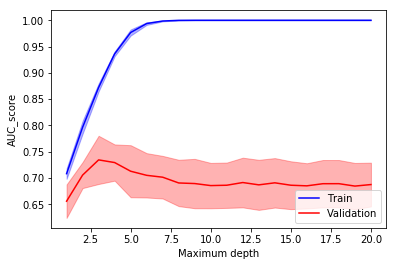

In [17]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Maximum depth")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

### ¿Cómo se afectan el sesgo y la varianza al aumentar la profundidad del árbol?

En un primer rango (de 1 a 4), a mayores valores de profundidad de árbol de decisión, el error de clasificación sobre los datos de entrenamiento y validación disminuye; por lo que disminuye el sesgo de los modelos producidos por el algoritmo. Por otro lado, a partir de 4, a mayores valores de profundidad, el desempeño sobre los datos de entrenamiento sigue aumentando, pero el desempeño sobre los datos de validación disminuye, indicio de que aumenta la varianza de los modelos generados.

(Además se evaluó con valores de profundidades aún mayores al gráfico (50,100,1000) sin diferencias notables).


### SVC

In [34]:
# Tomo el mejor gamma y el mejor kernel encontrado mediante RandomSearch y GridSearch

#params=[0.01,0.1,1,10,100,1000] # Cs
#params=list(np.arange(0.10,0.25,0.01))+[0.5,0.75,1,1.5,2,3]
params=[0.00001,0.0001, 0.001, 0.1, 1, 10, 100,1000]
#params=[50,60,70,80,90,100,110,120,130,140,150]

dic={}
for c in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for rep in range(10):
        nkfold = StratifiedKFold(n_splits=5)
        nkfold.get_n_splits(X_desarrollo,y_desarrollo)
        for train, test  in nkfold.split(X_desarrollo,y_desarrollo):
            X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
            y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

            model=SVC(C=c,kernel="rbf",gamma=0.0001,probability=True) #0.00707269
            model.fit(X_train,y_train)

            ROC_AUC_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
            ROC_AUC_val.append(roc_auc_score(y_val,model.predict_proba(X_val)[:,1]))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params)

,train_score_err,train_score_mean,val_score_err,val_score_mean
0.00001,0.005089,0.859526,0.036410,0.825038
0.00010,0.005125,0.859526,0.036409,0.825038
0.00100,0.050580,0.852267,0.057949,0.819538
0.10000,0.005136,0.860211,0.036644,0.824609
1.00000,0.005640,0.860660,0.036345,0.824822
10.00000,0.006360,0.933046,0.043011,0.840533
100.00000,0.003252,0.982311,0.053101,0.788986
1000.00000,0.000000,1.000000,0.053237,0.756796


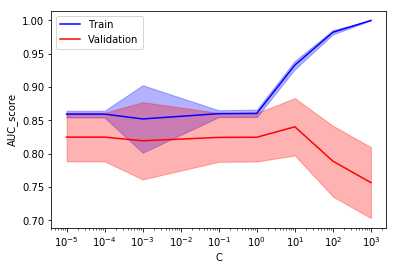

In [35]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

### ¿Cómo se afectan el sesgo y la varianza al aumentar el valor de C?
El hiperparámetro C controla un tradeoff entre maximizar el margen de separación entre los casos de entrenamiento de diferente categoría, y clasificar correctamente la mayor cantidad de casos (disminuir el error de entrenamiento). A mayores valores de C menor el error de entrenamiento, pero tiende a aumentar la varianza, por lo que tiende a aumentar el error de validación. 

En el gráfico se observa un rango de C (entre 1 y 10) donde aumenta el desempeño de los modelos sobre los datos de entrenamiento y validación, por lo que se puede suponer que disminuye el sesgo. Luego, para valores mayores a 10 se observa que el desempeño de los modelos sobre los datos de validación disminuye, asociado a que aumenta la varianza de los modelos.


## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.2

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [22]:
from sklearn.model_selection import learning_curve

### Árboles

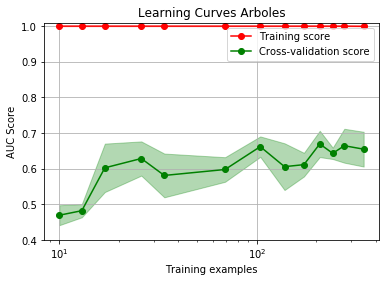

In [23]:
estimator = DecisionTreeClassifier(max_depth=10)

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(estimator, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1,train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


title = "Learning Curves Arboles"
ylim=(0.4, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
plt.show()

### SVC

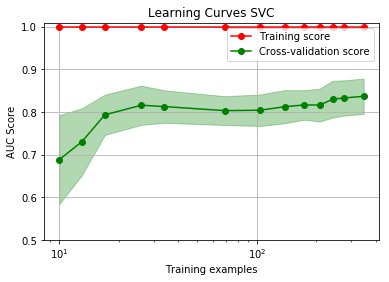

In [24]:
model = SVC(C=50,kernel="rbf",gamma=0.00707269)

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(model, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


title = "Learning Curves SVC"
ylim=(0.5, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
plt.show()

### ¿Más datos permitirían obtener mejores modelos?
Ambos algoritmos alcanzan rápidamente (con pocas instancias) un desempeño máximo de los modelos que generan. Esto indica que aumentar la cantidad de datos no mejoraría los modelos obtenidos mediante estos algoritmos (al menos con los hiperparámetros utilizados).
Si bien se puede notar una pequeña tendencia ascendente al final para el caso de SVC, esta tendencia es muy leve, y teniendo en cuenta que conseguir nuevos datos suele ser caro, no sería aconsejable ir por ese lado, dado que probablemente la tendencia ascendente esté encontrando su límite.

## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.3

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

### GridSearch

In [25]:
param_grid = {'max_features': ['sqrt', 'log2']+range(0,201,20)[1:],
              'max_depth' : range(4,20),
              'criterion' :['gini', 'entropy']}

model=RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1)
RFgrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)
RFgrid.fit(X_desarrollo, y_desarrollo);

RFgrid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=11, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Curva de max_features

In [26]:
params=range(0,201,20)[1:]

dic={}
for c in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

        model=RFgrid.best_estimator_
        model.max_features=c
        model.fit(X_train,y_train)

        ROC_AUC_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict_proba(X_val)[:,1]))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params);

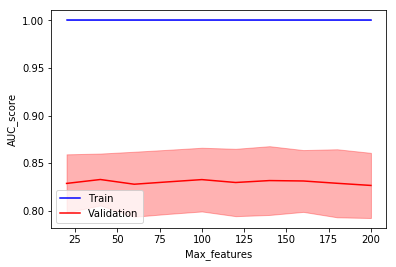

In [27]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Max_features")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

### ¿Por qué creen que se dieron los resultados obtenidos?

Según la literatura, aumentar el parámetro max_features por un lado aumenta la complejidad de los árboles (pudiendo mejorar el desempeño de cada arbol), pero también disminuye la diversidad de los árboles del conjunto, elemento fundamental de un modelo RandomForest. Por lo tanto no es trivial encontrar un max_features óptimo. Cabe mencionar que aumentar este parámetro impacta en el tiempo que tarda el algoritmo en entrenarse.

En nuestro caso, no se observó una diferencia notable entre ningún valor de max_features; quizás los efectos mencionados se compensaron.   


### Curva de aprendizaje

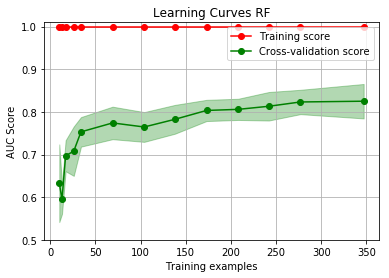

In [28]:
#model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=11,max_features=15, 
#                               max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1, 
#                               min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=200, n_jobs=-1,
#                               oob_score=False,random_state=42,verbose=0, warm_start=False)

model = RFgrid.best_estimator_

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(model, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


title = "Learning Curves RF"
ylim=(0.5, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
#plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
plt.show()

### ¿Sería útil o no conseguir más datos?
El algoritmo alcanza rápidamente (con pocas instancias) un desempeño máximo de los modelos que genera. Esto indica que aumentar la cantidad de datos no mejoraría los modelos obtenidos mediante este algoritmo (al menos con los hiperparámetros utilizados).
Cabe mencionar lo mismo que en el caso de la curva de aprendizaje para SVC sobre la pequeña tendencia creciente al final de la curva, en el sentido de que en este caso la tendencia también es demasiado chica como para arriesgarse a buscar nuevos datos.

## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# Ejercicio Extra

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [29]:
mxf=range(0,201,20)[1:]
mxf.extend(['sqrt', 'log2'])
param_grid = {'max_features': mxf,
              'max_depth' : sp.stats.randint(2,20), 
              'learning_rate': np.logspace(-3,0,num=50),
              'n_estimators':sp.stats.randint(10,200)}

model=GradientBoostingClassifier() #random_state = 0

GBCgrid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)
GBCgrid.fit(X_desarrollo, y_desarrollo);

GBCgrid.best_estimator_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0030888435964774815, loss='deviance',
              max_depth=17, max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=123,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### Curva de aprendizaje

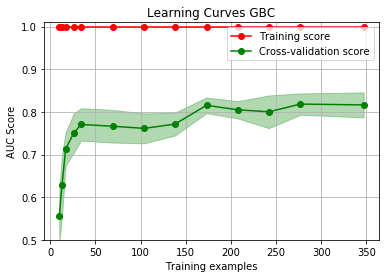

In [30]:
model=GBCgrid.best_estimator_

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(model, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

title = "Learning Curves GBC"
ylim=(0.5, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
#plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
#plt.show()

La curva de aprendizaje indica que el desempeño de los modelos generados por el algoritmo llegó a un límite; por tanto, utilizando este algoritmo con los hiperparámetros seleccionados, más datos no generarían un mejor modelo.  

La curva de aprendizaje de GBC resulta muy similar a la curva de aprendizaje de Random Forest, tanto en forma como en desempeño máximo de los modelos.

# _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

# -:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-: Competencia :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

## Elección de mejor algoritmo

In [32]:
model=RFgrid.best_estimator_
model.fit(X_desarrollo,y_desarrollo)
y_pred=model.predict_proba(X_holdout)[:,1]

print(model)
roc_auc_score(y_holdout,y_pred)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=11, max_features=200, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


0.90095238095238095

In [33]:
model=GBCgrid.best_estimator_
model.fit(X_desarrollo,y_desarrollo)
y_pred=model.predict_proba(X_holdout)[:,1]

print(model)
roc_auc_score(y_holdout,y_pred)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0030888435964774815, loss='deviance',
              max_depth=17, max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=123,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


0.85904761904761906

In [ ]:
model=RFgrid.best_estimator_
model.fit(X_desarrollo,y_desarrollo)
y_comp_pred=model.predict_proba(X_comp)

In [ ]:
y_comp_pred_df=pd.DataFrame(y_comp_pred)
y_comp_pred_df.drop([0],inplace=True, axis=1)
y_comp_pred_df.to_csv("y_predicciones_competencia.csv")


#### Durante el entrenamiento de los distintos modelos, los mejores resultados se obtuvieron con los algoritmos RandomForest y GBC. Estos no mostraban diferencias notables entre ellos.
#### Utilizamos el hold out set para optar por uno de los modelos generados.
#### En base a los resultados sobre el holdout set, esperamos tener un AUC score de 0.90 en la competencia.